In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy import optimize

In [2]:
station_list_north = ["POLESOUT", "KISSR0.0", "LZ2", "S133", "TCNS228", "S135"]
station_list_south = ["PALMOUNT", "S169", "S236", "POLE3S", "RITTAE2", "LZ2FA", "L007", "PELBAY3", "L006", "LZ30"]
station_list_middle = ["FEBIN", "MBOXSOU", "MH24000", "FEBOUT", "L005", "L008", "LZ40", "L004", "S308C"]
unknonwn_station = ["TIN16100", "TIN13700"] #North
unknonwn_station = ["MH32000"]#Middle

In [3]:
def Clean_date(df):
    for index, value in enumerate(df["Collection_Date"]):
        df["Collection_Date"][index] = datetime.datetime.strptime(value, '%Y-%m-%d %H:%M:%S')        
    return df

In [4]:
def Import_data(station):
    """
    Import the raw dataset. The station name is the name of the dataset. 
    """
    data = pd.read_csv(f"{station}.csv")
    return Clean_date(data)

In [5]:
def Request_monthly_data(station, variable, year):
    """
    Request the data with the given station name from the downloaded csv files.
    Select data with the given variable and year.
    Return with the monthly value of that variable and the unit of the values.
    """
    data = pd.read_csv(f"{station}.csv")
    data = Clean_date(data)
    chosen_rows = (data["Test Name"]==variable)&([x.year == year for x in data["Collection_Date"]])
    chosen_columns = ["Collection_Date", "Value", "Units"]
    year_data = data.loc[chosen_rows, chosen_columns]

    monthly_values = []
    for month in np.arange(1,13,1):
        values = year_data.loc[([x.month == month for x in year_data["Collection_Date"]])&(year_data["Value"]>0), "Value"]
        monthly_values.append(np.mean(values))
    
    #Check if the units are inconsistent:
    list_units = list(year_data["Units"])
    if len(list_units) > 0:
        chosen_unit = list_units[0]
        for unit in list_units:
            if unit != list_units[0]:
                chosen_unit = "Inconsistent Units"
                break
    else:
        chosen_unit = None
    return np.array(monthly_values), chosen_unit

In [6]:
def Plot_monthly_data(stations, variable, year):
    plt.figure(figsize=(10,5))
    for station in stations:
        monthly_data, unit = Request_monthly_data(station, variable, year)
        if unit == "Inconsistent Units":
            print(f"Inconsistent Units at {station}")
        plt.plot(np.arange(1,13), monthly_data, label = station)
        
    plt.xlabel("Month")
    plt.ylabel(f'{variable} ({unit})')
    plt.title(f"Year: {year}")
    plt.legend()
    plt.xticks(np.arange(1,13),np.arange(1,13))
    plt.show()

In [7]:
def LogisticFunction(x, a, b, c):
    return a/(1+np.exp(-b*(x-c)))

In [8]:
def LogisticFunction2(x, a, b):
    global c
    return a/(1+np.exp(-b*(x-c)))

In [9]:
def ManualLogisticOptimization(X_array, Y_array):
    """
    Iterate through differnt values of c. At each value of c, we calculate the optimize parameters a and b.
    At each iteration, we calculate the difference between the prediction and the actual. 
    The value of c (and corresponding optimized a and b) with the lowest difference between prediction and actual will be chosen
    """ 
    chosen_a = []
    chosen_b = []
    chosen_c = []
    accuracy_array = []
    
    for c in np.linspace(0,10,100):
        params, params_covariance = optimize.curve_fit(LogisticFunction2, X_array, Y_array)
        a, b = params
        #Make prediction:
        y_pred = LogisticFunction(X_array, a, b, c)
        #Compare prediction with the actual:
        accuracy = Accuracy(y_pred=y_pred, y_actual=Y_array)
        #Store the values:
        chosen_c.append(c)
        accuracy_array.append(accuracy)
        
    return chosen_c, accuracy_array

In [10]:
def Datablabla(station="POLESOUT", var1="TOTAL NITROGEN", var2="CHLOROPHYLL-A(LC)",year=2017, logistic=True, cross_validation=True):
    xvas,xunit = Request_monthly_data(station=station, variable=var1, year=year)
    yvas,yunit = Request_monthly_data(station=station, variable=var2, year=year)
    return xvas, yvas

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


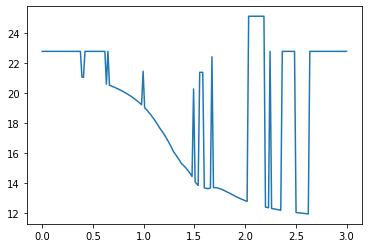

In [18]:
X_array, Y_array = Datablabla()
chosen_c = []
accuracy_array = []

for c in np.linspace(0,3,200):
    params, params_covariance = optimize.curve_fit(LogisticFunction2, X_array, Y_array)
    a, b = params
    #Make prediction:
    y_pred = LogisticFunction(X_array, a, b, c)
    #Compare prediction with the actual:
    accuracy = Accuracy(y_pred=y_pred, y_actual=Y_array)
    #Store the values:
    chosen_c.append(c)
    accuracy_array.append(accuracy)

plt.plot(chosen_c, accuracy_array)
plt.show()

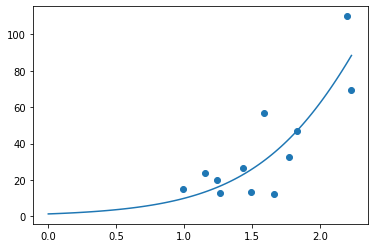

In [19]:
minval = min(accuracy_array)
index = accuracy_array.index(minval)
c = chosen_c[index]

plt.figure()
plt.scatter(X_array, Y_array)
params, params_covariance = optimize.curve_fit(LogisticFunction2, X_array, Y_array)
a, b = params
#Make prediction:
X_pred = np.linspace(0, max(X_array),100)
Y_pred = LogisticFunction(X_pred, a, b, c)
plt.plot(X_pred, Y_pred)
plt.show()

In [12]:
def RemoveNAs(X_array, Y_array):
    """
    Remove NAs values from X_array and Y_array
    """
    New_X_array = []
    New_Y_array = []
    for x, y in zip(X_array, Y_array):
        if np.isnan(x) == False and np.isnan(y) == False:
            New_X_array.append(x)
            New_Y_array.append(y)
    return New_X_array, New_Y_array

In [13]:
def Accuracy(y_pred, y_actual):
    return np.mean(abs(y_pred-y_actual))

In [14]:
def CrossValidation(X_array, Y_array, logistic = True):
    """
    Iterate through all the datapoints. 
    At each datapoint, we exclude that datapoint from the dataset,
    then, we make model based on the rest of the dataset. 
    That model is then used to predict the excluded datapoint. 
    We compare the predicted vs. the original value of that datapoint.
    """
    Result = []
    if logistic:
        for x, y in zip(X_array, Y_array):
            #Only use the datapoints where both x and y are not None:
            if x != None and y != None:
                ValidateX = [value for value in X_array if value!=x]
                ValidateY = [value for value in Y_array if value != y]
                params, params_covariance = optimize.curve_fit(LogisticFunction, X_array, Y_array, method="dogbox")
                a, b, c = params
                #Apply the optimized parameters to predict the excluded datapoint:
                y_pred = LogisticFunction(x, a, b, c)
                #Compare the predicted vs. the orginal value of y:
                accuracy = abs(y_pred - y)
                #Store the comparison:
                Result.append(accuracy)
    return Result

In [15]:
def ScatterPlot(station="POLESOUT", var1="TOTAL NITROGEN", var2="CHLOROPHYLL-A(LC)",year=2016, logistic=True, cross_validation=True):
    xvas,xunit = Request_monthly_data(station=station, variable=var1, year=year)
    yvas,yunit = Request_monthly_data(station=station, variable=var2, year=year)
    plt.figure(figsize=(15,5))
    plt.scatter(xvas, yvas, label="Actual")
    if logistic:
        xvas, yvas = RemoveNAs(xvas, yvas)
        params, params_covariance = optimize.curve_fit(LogisticFunction, xvas, yvas, method="dogbox")
        a, b, c = params
        xpred = np.linspace(min(xvas),max(xvas),100)
        ypred = LogisticFunction(xpred, a, b, c)
        plt.plot(xpred,ypred,label=f"Logistic model")
    plt.xlabel(f"{var1} ({xunit})")
    plt.ylabel(f"{var2} ({yunit})")
    plt.title(f"{station} {year}")
    plt.legend()
    plt.show()
    if cross_validation:
        result = CrossValidation(X_array=xvas, Y_array=yvas, logistic=logistic)
        plt.figure()
        plt.hist(result)
        plt.show()

In [16]:
def ScatterPlotAllYears(station="POLESOUT", var1="TOTAL NITROGEN", var2="CHLOROPHYLL-A(LC)", logistic=True, cros_validation=True):
    xvas = [] #Store values of variable 1 (var1)
    yvas = [] #Store values of variable 2 (var2)
    
    #Request data from 2010 to 2019:
    for year in np.arange(2010,2020):
        year_data_x, xunit = Request_monthly_data(station=station, variable=var1, year=year)
        year_data_y, yunit = Request_monthly_data(station=station, variable=var2, year=year)
        #store data in each year to xvas and yvas:
        xvas = np.concatenate((xvas,year_data_x), axis=None)
        yvas = np.concatenate((yvas,year_data_y), axis=None)
        
    #Make scatter plot for the xvas and yvas:
    plt.figure()
    plt.scatter(xvas, yvas, label="Actual")
    if logistic:
        xvas, yvas = RemoveNAs(xvas, yvas)
        params, params_covariance = optimize.curve_fit(LogisticFunction, xvas, yvas, method="dogbox")
        a, b, c = params
        xpred = np.linspace(min(xvas),max(xvas),100)
        ypred = LogisticFunction(xpred, a, b, c)
        plt.plot(xpred,ypred,label=f"Logistic model")
    plt.xlabel(f"{var1} ({xunit})")
    plt.ylabel(f"{var2} ({yunit})")
    plt.title(f"{station}")
    if logistic:
        plt.legend()
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


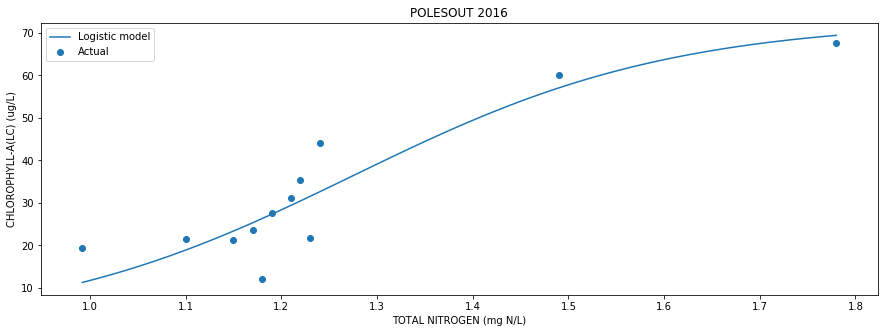

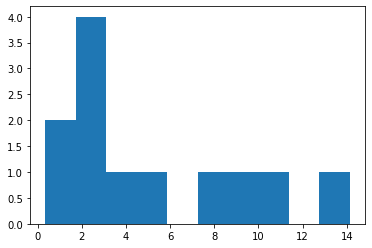

In [17]:
ScatterPlot(station="POLESOUT", var1='TOTAL NITROGEN', var2="CHLOROPHYLL-A(LC)",year=2016,logistic=True,cross_validation=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


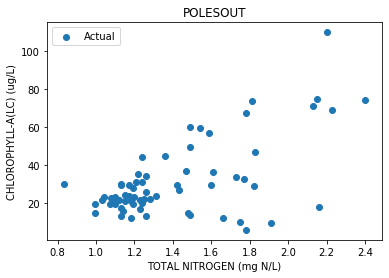

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (17,18,26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


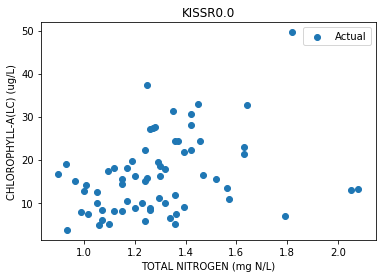

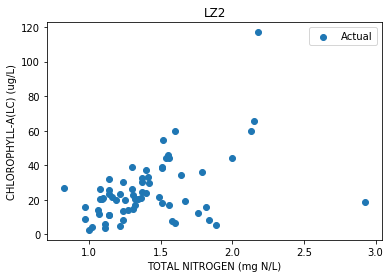

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


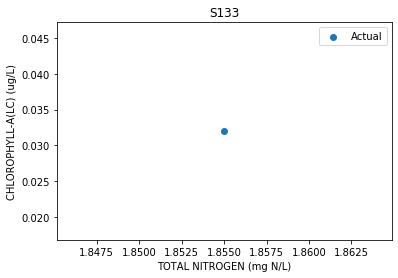

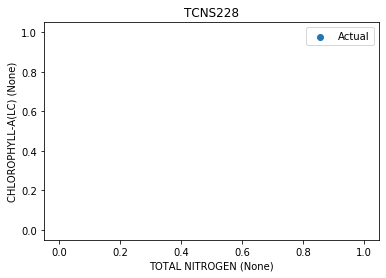

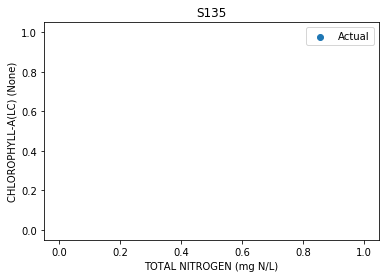

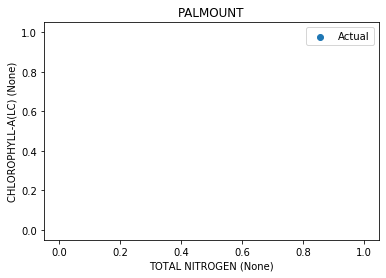

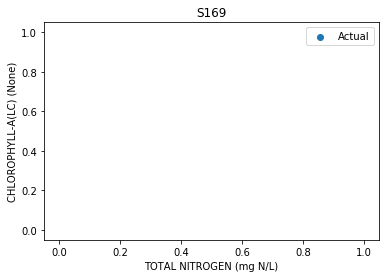

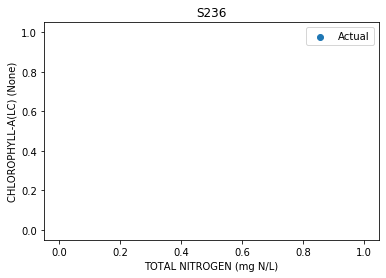

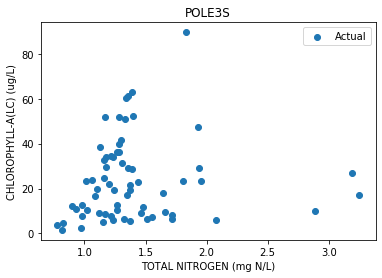

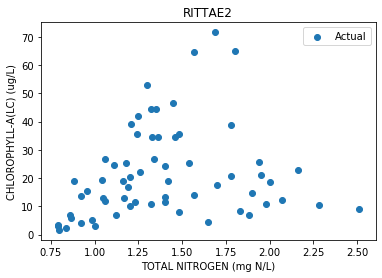

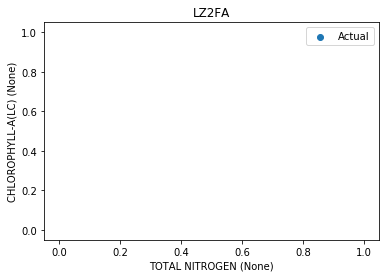

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9,17,18,26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


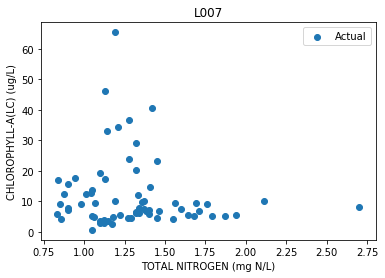

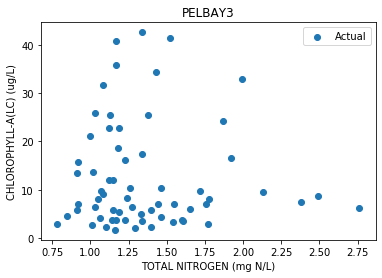

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9,14,15,18,25,27,31,32,38) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


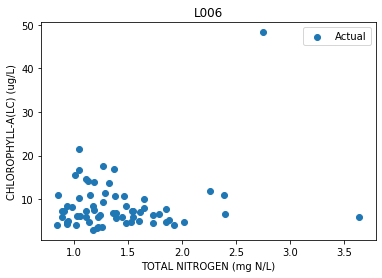

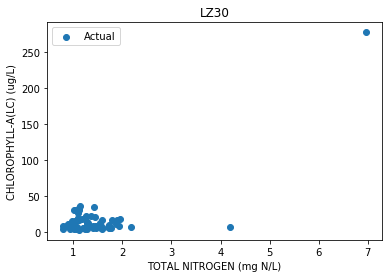

In [18]:
for station in np.concatenate((station_list_north,station_list_south),axis=None):
    ScatterPlotAllYears(station=station, var1="TOTAL NITROGEN")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


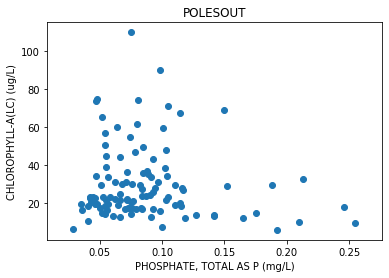

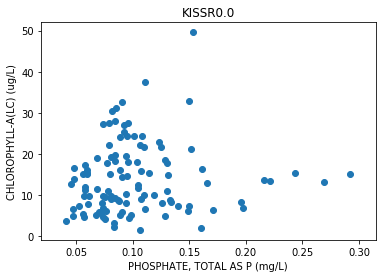

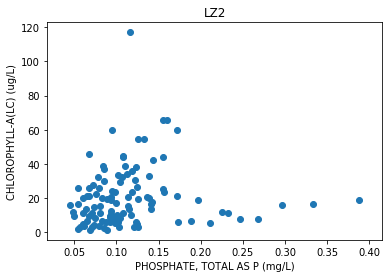

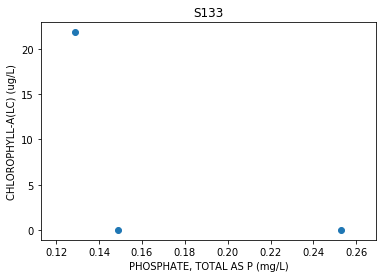

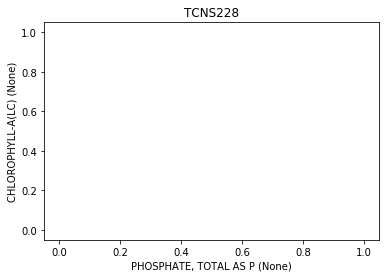

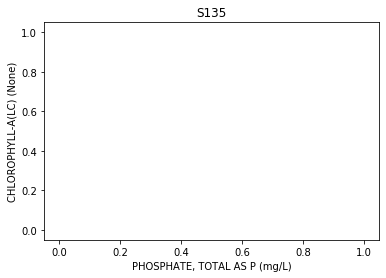

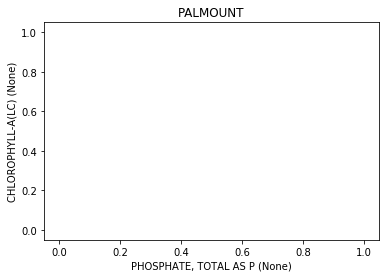

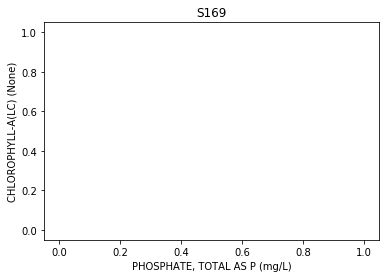

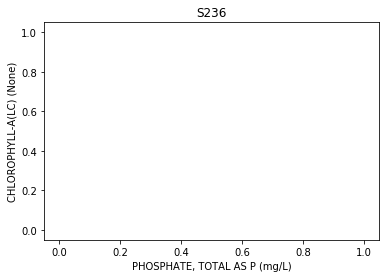

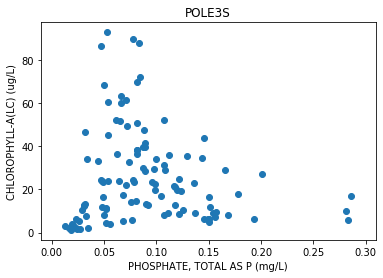

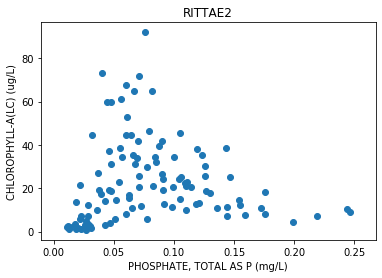

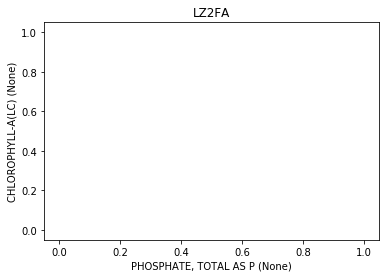

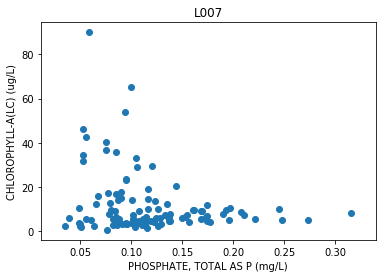

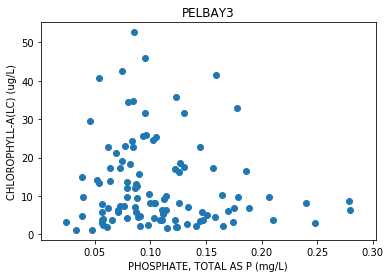

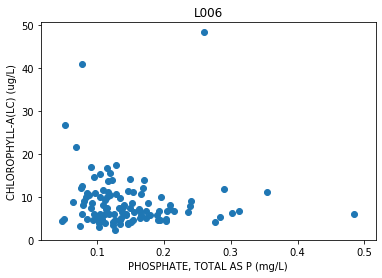

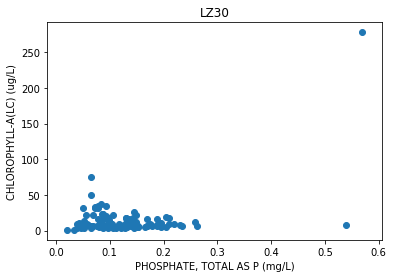

In [21]:
for station in np.concatenate((station_list_north,station_list_south),axis=None):
    ScatterPlotAllYears(station=station, var1='PHOSPHATE, TOTAL AS P')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


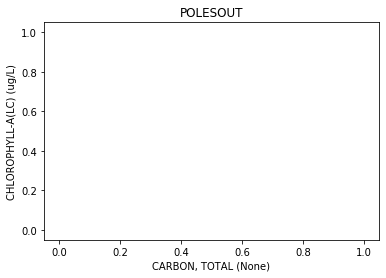

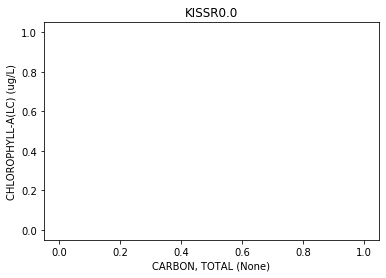

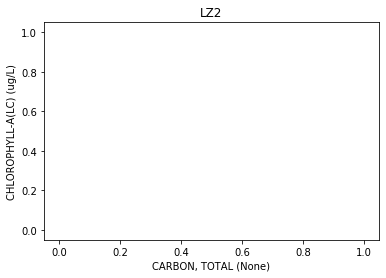

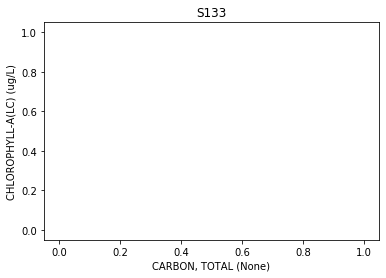

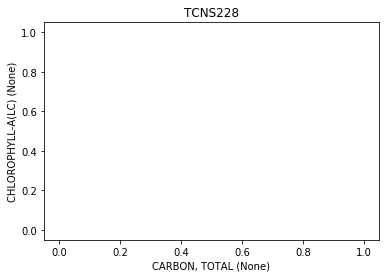

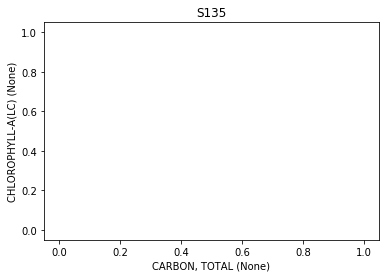

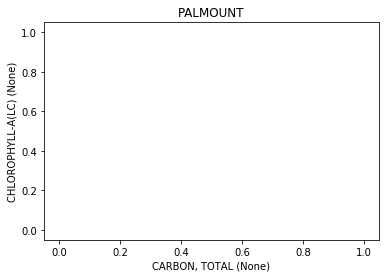

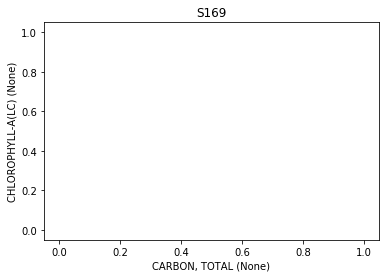

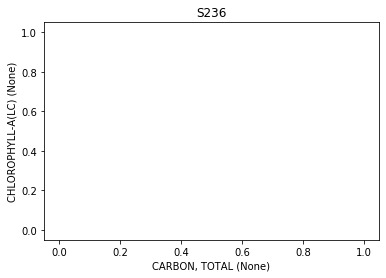

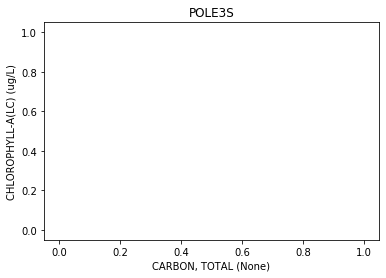

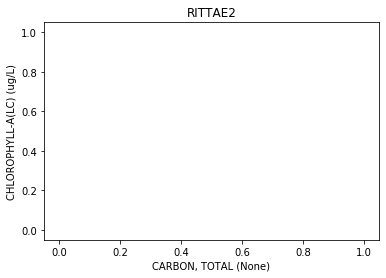

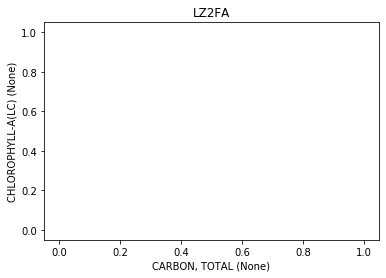

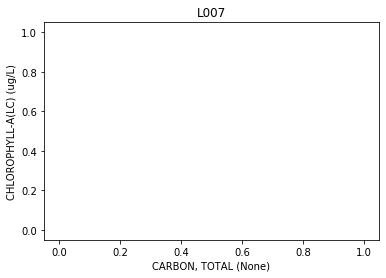

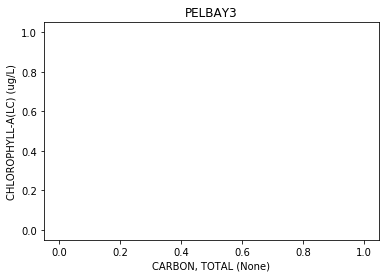

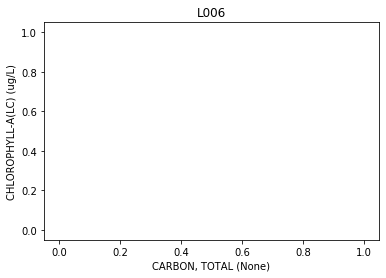

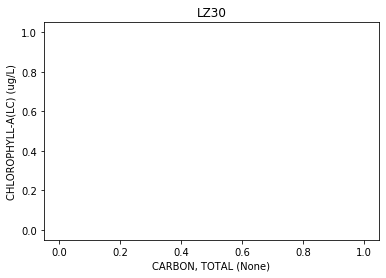

In [22]:
for station in np.concatenate((station_list_north,station_list_south),axis=None):
    ScatterPlotAllYears(station=station, var1='CARBON, TOTAL')

Stations with Chlorophyll-A (LC) records (number of records since 2019): 
- North: POLESOUT (21), KISSR0.0 (62), LZ2 (21), 
- South: POLE3S (16), RITTAE2 (16), L007 (19), PELBAY3 (18), L006 (18), LZ30 (38)
- Middle: L005 (21), L008 (21), LZ40 (20), L004 (21), S308C (80).

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (17,18,26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


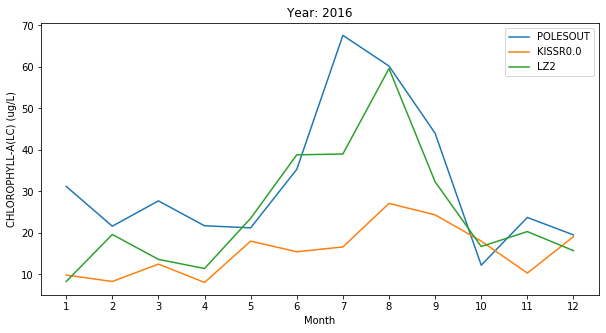

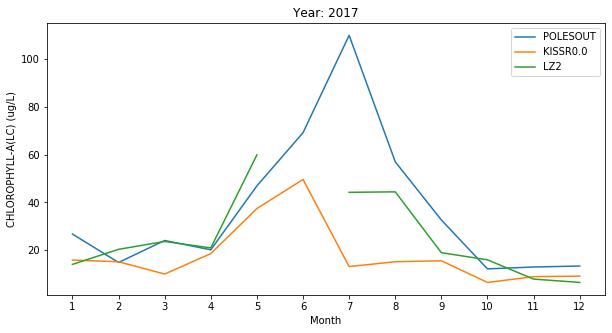

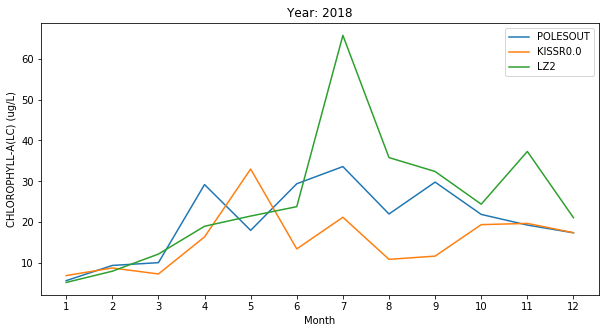

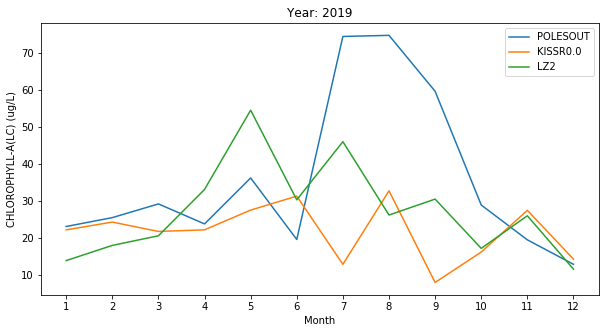

In [6]:
stations = ["POLESOUT", "KISSR0.0", "LZ2"]
for year in [2016, 2017, 2018, 2019]:
    Plot_monthly_data(stations=stations, variable="CHLOROPHYLL-A(LC)", year=year)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9,17,18,26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9,14,15,18,25,27,31,32,38) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


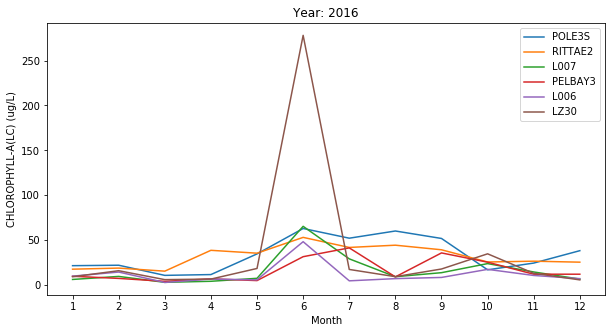

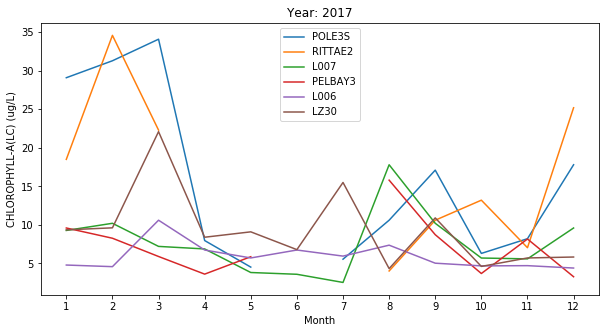

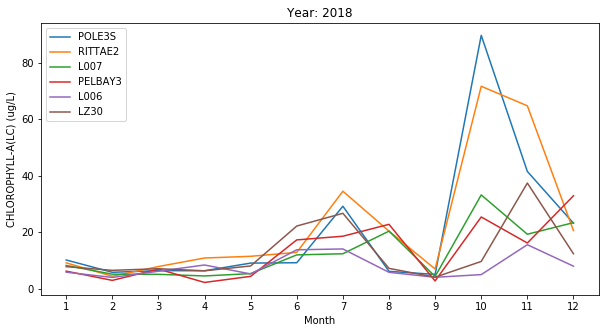

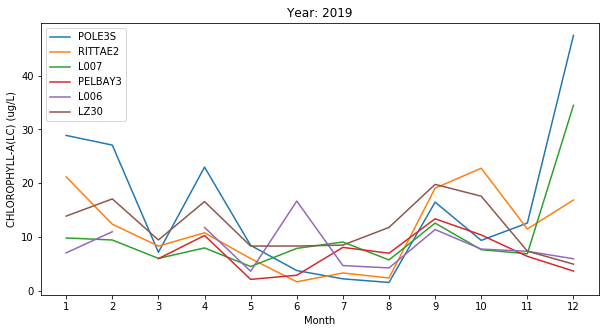

In [7]:
stations = ["POLE3S", "RITTAE2", "L007", "PELBAY3", "L006", "LZ30"]
for year in [2016, 2017, 2018, 2019]:
    Plot_monthly_data(stations=stations, variable="CHLOROPHYLL-A(LC)", year=year)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


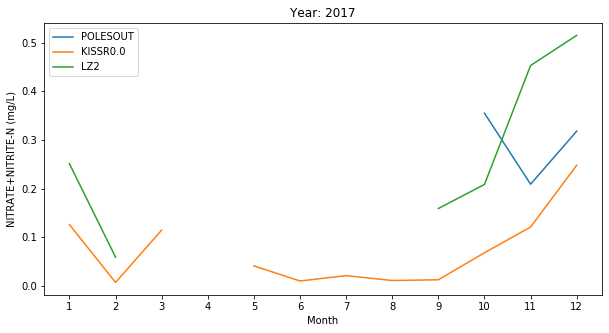

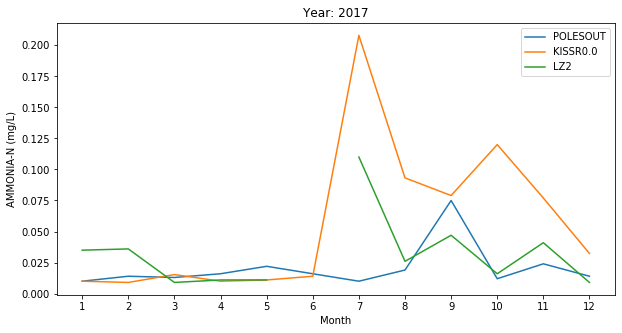

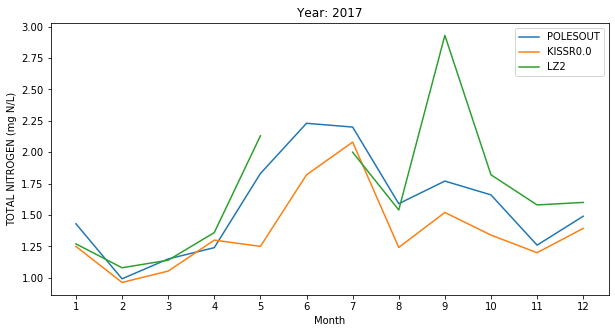

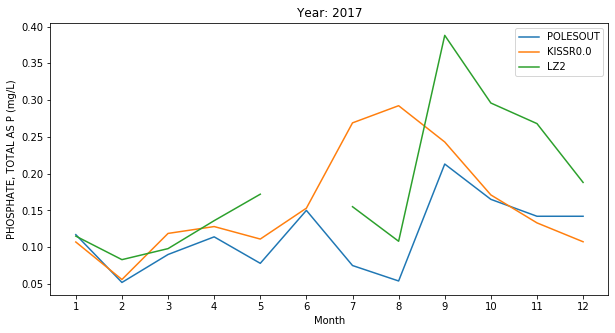

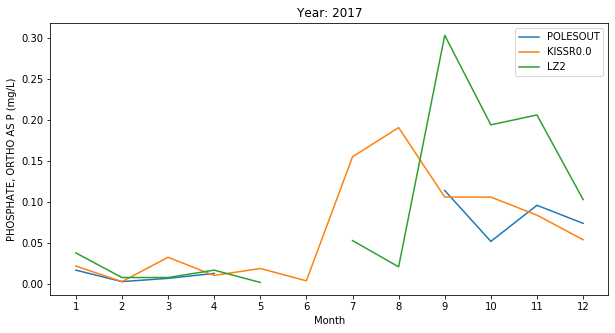

In [8]:
stations = ["POLESOUT", "KISSR0.0", "LZ2"]
for variable in ["NITRATE+NITRITE-N", "AMMONIA-N", "TOTAL NITROGEN", "PHOSPHATE, TOTAL AS P", "PHOSPHATE, ORTHO AS P"]:
    Plot_monthly_data(stations=stations, variable=variable, year=2017)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


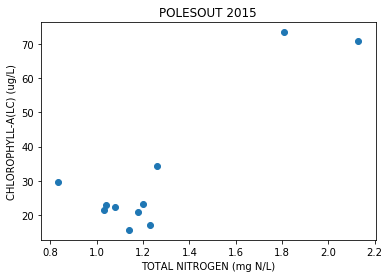

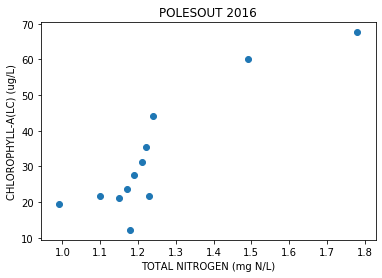

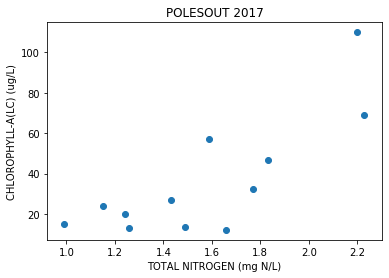

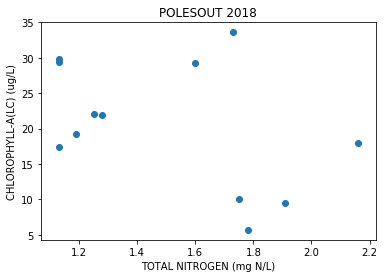

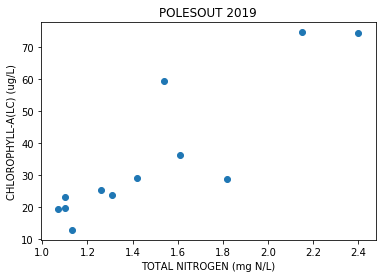

In [11]:
for year in [2015, 2016, 2017, 2018, 2019]:
    ScatterPlot(station="POLESOUT", year=year)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


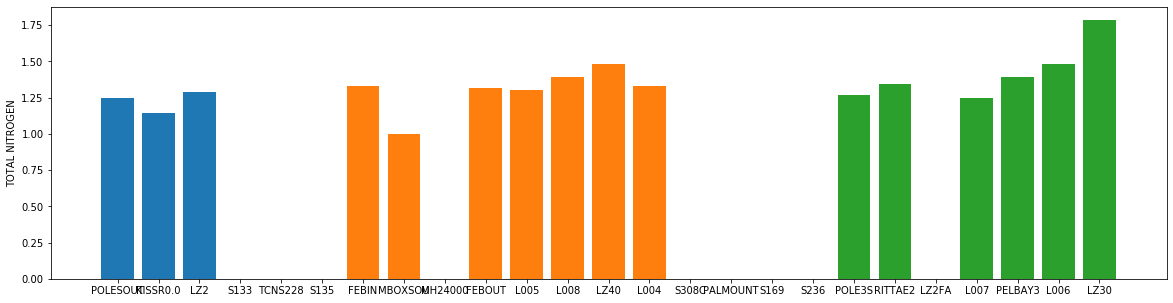

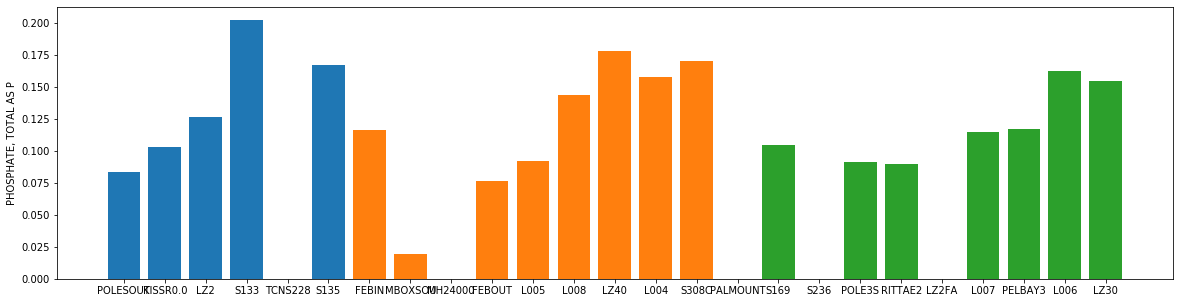

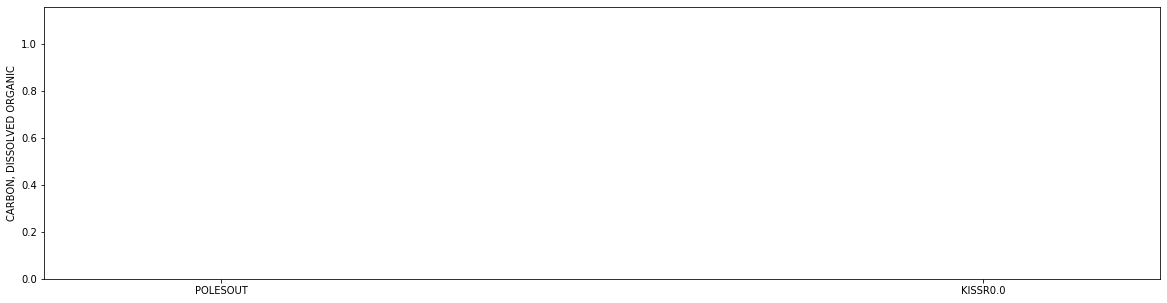

In [27]:
for variable in ['TOTAL NITROGEN', 'PHOSPHATE, TOTAL AS P', 'CARBON, DISSOLVED ORGANIC']:
    plt.figure(figsize=(20,5))
    for regional_list in [station_list_north, station_list_middle, station_list_south]:
        means = []
        stds = []
        for station in regional_list:
            station_data = Request_monthly_data(station=station, variable=variable, year=2016)[0]
            if len(station_data) > 0:
                means.append(np.mean(station_data))
                stds.append(np.std(station_data))
            else:
                means.append(None)
                stds.append(None)

        plt.bar(regional_list, means)
    plt.ylabel(variable)    
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


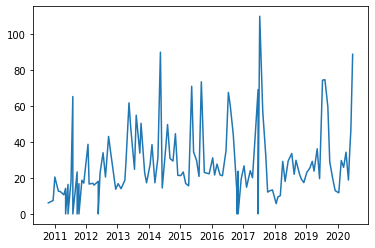

In [29]:
data = Import_data("POLESOUT")
data = data.loc[data["Test Name"]=='CHLOROPHYLL-A(LC)',["Collection_Date", "Value", "Units"]]
plt.plot(data["Collection_Date"], data["Value"])
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


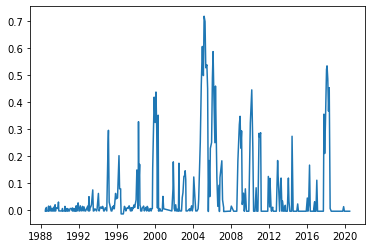

In [44]:
data2 = Import_data("POLESOUT")
data2 = data2.loc[data2["Test Name"]=='NITRATE+NITRITE-N',["Collection_Date", "Value", "Units"]]
plt.plot(data2["Collection_Date"], data2["Value"])
plt.show()